In [42]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [43]:
from exp.nb_05 import *

In [44]:
from IPython.core.debugger import set_trace

## Early stopping

### Better callback cancellation

In [45]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [46]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [47]:
pp(camel2snake("TrainEvalCallback"), camel2snake("after_cancel_batch"))


train_eval_callback
------------------------------------------------------------------------------------------------------------------------
after_cancel_batch
------------------------------------------------------------------------------------------------------------------------


In [48]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        print(f"self.model.train of: {self}")
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [49]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
#         set_trace()
        
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
#         set_trace()
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
#         set_trace()
        res = True
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [50]:
learn = create_learner(get_model, loss_func, data)

In [51]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(f'{self}, {self.n_iter}')
#         set_trace()
        if self.n_iter >= 10 : raise CancelTrainException()

In [52]:
run = Runner(cb_funcs=TestCallback)

In [53]:
run.fit(3, learn)

self.model.train of: <__main__.TrainEvalCallback object at 0x7f9184a57208>
<__main__.TestCallback object at 0x7f91848f0438>, 0
<__main__.TestCallback object at 0x7f91848f0438>, 1
<__main__.TestCallback object at 0x7f91848f0438>, 2
<__main__.TestCallback object at 0x7f91848f0438>, 3
<__main__.TestCallback object at 0x7f91848f0438>, 4
<__main__.TestCallback object at 0x7f91848f0438>, 5
<__main__.TestCallback object at 0x7f91848f0438>, 6
<__main__.TestCallback object at 0x7f91848f0438>, 7
<__main__.TestCallback object at 0x7f91848f0438>, 8
<__main__.TestCallback object at 0x7f91848f0438>, 9
<__main__.TestCallback object at 0x7f91848f0438>, 10


### Other callbacks

In [54]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

### LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [62]:
#export
class LR_Find(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,  self.max_lr = max_iter,min_lr,  max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return 
        pos = self.n_iter/ self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr)**pos
        for pg in self.opt.param_groups: pg['lr'] = lr
        
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss
            

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [63]:
learn = create_learner(get_model, loss_func, data)

In [64]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [65]:
run.fit(2, learn)

self.model.train of: <__main__.TrainEvalCallback object at 0x7f91198c1358>


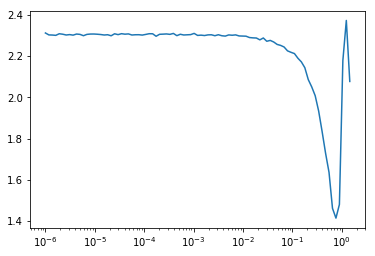

In [66]:
run.recorder.plot(skip_last=5)

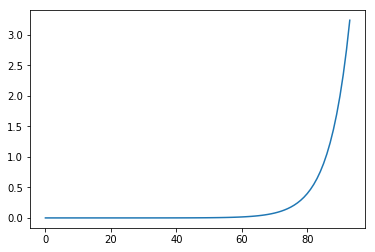

In [67]:
run.recorder.plot_lr()

## Export

In [68]:
!python notebook2script.py 05b_early_stopping.ipynb

Converted 05b_early_stopping.ipynb to exp/nb_05b.py
